In [1]:
import os
import pathlib

In [2]:

import matplotlib
import matplotlib.pyplot as plt

import scipy.misc
import skimage
from skimage import io
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

In [4]:
def load_image_into_numpy_array(path):
    img = io.imread(path)
    (width, height) = img.shape
    if img.ndim !=3:
        img = skimage.color.gray2rgb(img)
    img_arr = np.array(img).reshape((width, height, 3)).astype(np.uint8)
    return img_arr

In [5]:
pipeline_config = "/data/embryo/models/research/model.config"
model_dir = "/data/embryo/mask_rcnn/data/model_3/"
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs["model"]
detection_model = model_builder.build(model_config=model_config, is_training=False)


In [5]:
ckpt = tf.compat.v2.train.Checkpoint(model = detection_model)
ckpt.restore(os.path.join(model_dir, "ckpt-318"))

In [6]:
def get_model_detection_function(model):
  """Get a tf.function for detection."""

  @tf.function
  def detect_fn(image):
    """Detect objects in image."""

    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn

detect_fn = get_model_detection_function(detection_model)

In [8]:
label_map_path = configs['eval_input_config'].label_map_path
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

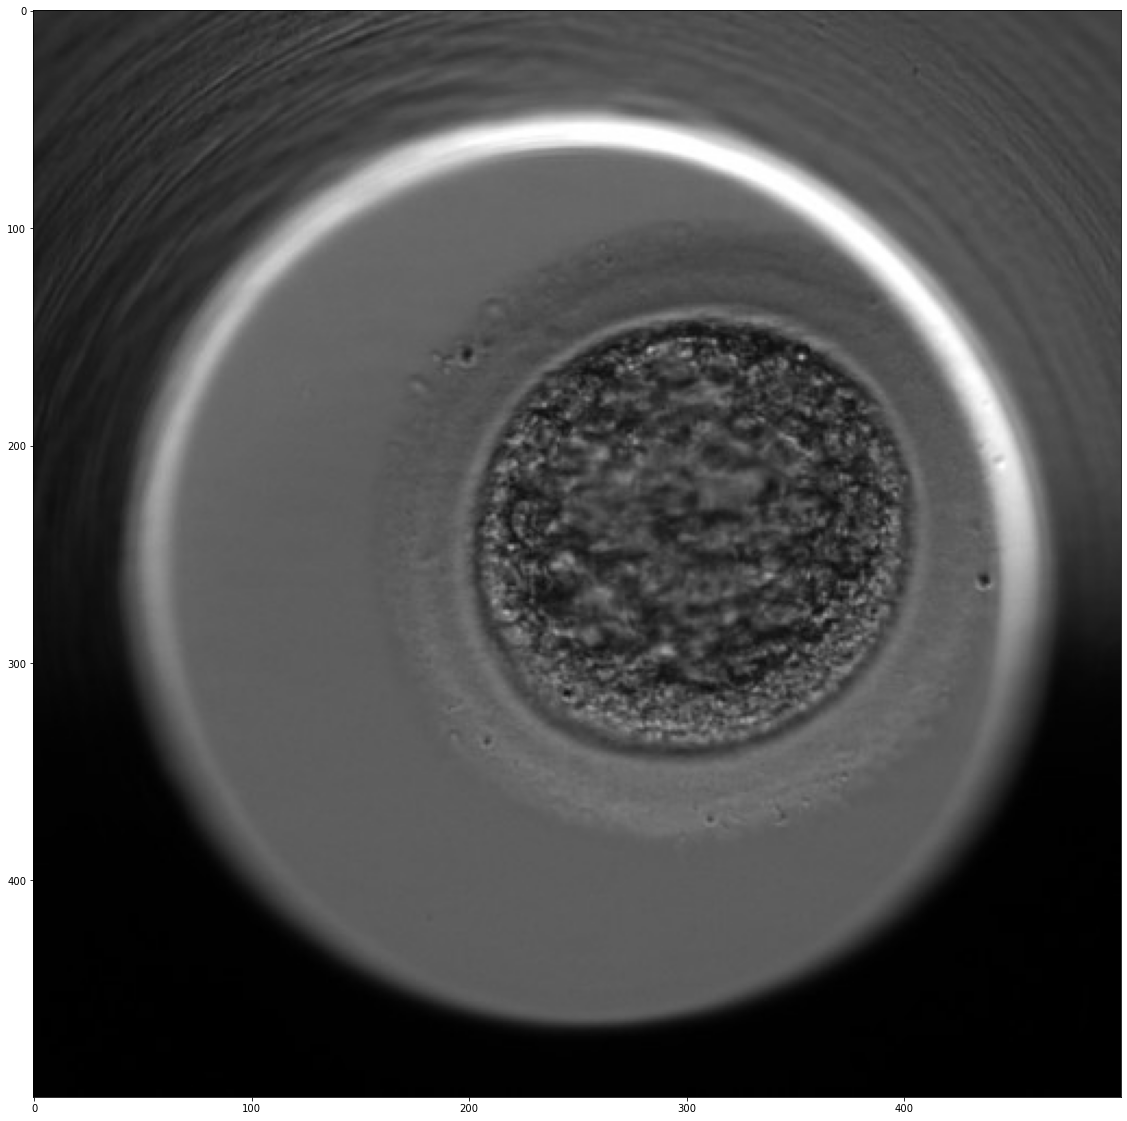

In [17]:
image_path = "/data/embryo/img/D2016_05_18_S0022_I776_E1/D2016_05_18_S0022_I776_E1_2461.jpg"
image_np = load_image_into_numpy_array(image_path)
input_tensor = tf.convert_to_tensor(
    np.expand_dims(image_np, 0), dtype=tf.float32)
detections, predictions_dict, shapes = detect_fn(input_tensor)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'][0].numpy(),
      (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
      detections['detection_scores'][0].numpy(),
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=2,
      min_score_thresh=.5,
      agnostic_mode=False)

plt.figure(figsize=(20,20))
plt.imshow(image_np_with_detections)
plt.show()